In [4]:
!pip install SimpleITK
!pip install opencv-python
!pip install SimpleITK
!pip install scipy
!pip install matplotlib

In [8]:
from google.cloud import storage
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
from skimage.color import rgb2gray
from skimage.io import imread
import numpy as np

import cv2
import datetime
import time

In [6]:
client = storage.Client()

bucket_name = 'marketplace-p115jwl6'  
image_1_path = 'MICCAI FLARE22/114/artifactFiles/FLARE22Train/images/FLARE22_Tr_0031_0000.nii.gz'
image_2_path = 'MICCAI FLARE22/114/artifactFiles/FLARE22Train/images/FLARE22_Tr_0003_0000.nii.gz'

bucket = client.get_bucket(bucket_name)

output_dir = 'ch13_ds'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

blob1 = bucket.blob(image_1_path)
local_file_path1 = os.path.join(output_dir, 'FLARE22_Tr_0031_0000.nii.gz')
blob1.download_to_filename(local_file_path1)
print(f"Downloaded: {local_file_path1}")

blob2 = bucket.blob(image_2_path)
local_file_path2 = os.path.join(output_dir, 'FLARE22_Tr_0003_0000.nii.gz')
blob2.download_to_filename(local_file_path2)
print(f"Downloaded: {local_file_path2}")


Downloaded: ch13_ds/FLARE22_Tr_0031_0000.nii.gz
Downloaded: ch13_ds/FLARE22_Tr_0003_0000.nii.gz


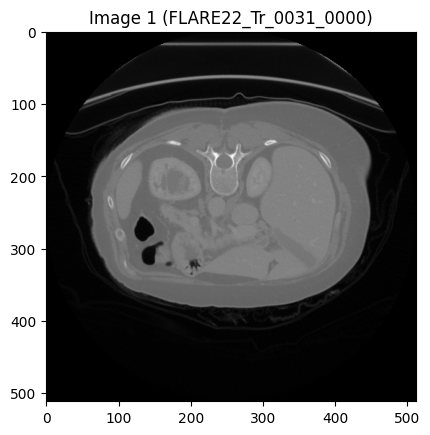

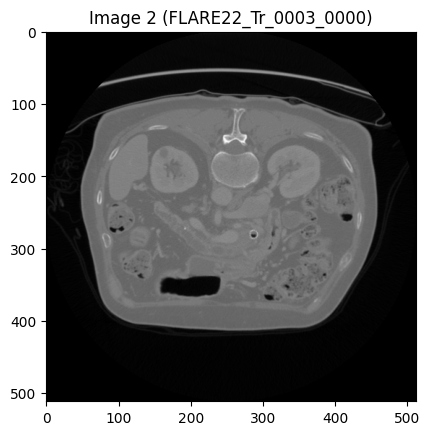

In [7]:
image1_path = 'ch13_ds/FLARE22_Tr_0031_0000.nii.gz'
image2_path = 'ch13_ds/FLARE22_Tr_0003_0000.nii.gz'

img1 = sitk.ReadImage(image1_path)
img2 = sitk.ReadImage(image2_path)

def show_image(image, title="Image"):
    array = sitk.GetArrayViewFromImage(image)
    mid_slice = array[array.shape[0] // 2]  #the middle slice
    plt.imshow(mid_slice, cmap='gray')
    plt.title(title)
    plt.show()

show_image(img1, "Image 1 (FLARE22_Tr_0031_0000)")
show_image(img2, "Image 2 (FLARE22_Tr_0003_0000)")


In [13]:
def load_center_slice_from_nifti(file_path):
    img = sitk.ReadImage(file_path)
    img_array = sitk.GetArrayFromImage(img)
    middle_slice = img_array[img_array.shape[0] // 2]
    middle_slice = middle_slice.astype(np.float64) / np.max(middle_slice)
    return middle_slice


def affine_transform_2d_double(Iin, M, order=3, mode=2, ImageSize=None):

    boundaries = ['reflect', 'grid-mirror', 'constant', 'grid-constant',
                  'nearest', 'mirror', 'grid-wrap', 'wrap']

    if ImageSize is None:
        ImageSize = [Iin.shape[0], Iin.shape[1]]

    if order not in np.arange(6):
        raise ValueError('Invalid order value')

    if mode not in np.arange(8):
        raise ValueError('Invalid mode value')

    boundary = boundaries[mode] # default = constant

    x, y = np.meshgrid(np.arange(ImageSize[1]), np.arange(ImageSize[0]))

    mean_out = np.array(ImageSize) / 2
    mean_in = np.array(Iin.shape[:2]) / 2

    xd = x - mean_out[1]
    yd = y - mean_out[0]

    Tlocalx = mean_in[1] + M[0, 0] * xd + M[0, 1] * yd + M[0, 2] * 1
    Tlocaly = mean_in[0] + M[1, 0] * xd + M[1, 1] * yd + M[1, 2] * 1

    Iout = map_coordinates(Iin, [Tlocaly, Tlocalx], order=order, mode=boundary)

    return Iout

def ncc(fixed_image, moving_image):
    fixed_mean = np.mean(fixed_image)
    moving_mean = np.mean(moving_image)
    fixed_diff = fixed_image - fixed_mean
    moving_diff = moving_image - moving_mean
    numerator = np.sum(fixed_diff * moving_diff)
    fixed_var = np.sum(fixed_diff ** 2)
    moving_var = np.sum(moving_diff ** 2)
    denominator = np.sqrt(fixed_var * moving_var)
    if denominator == 0:
        return 0
    ncc_value = numerator / denominator
    return -ncc_value # neg to maxmize

def ngc(fixed_image, moving_image):
    def compute_gradient(image):
        grad_x = np.gradient(image, axis=1)
        grad_y = np.gradient(image, axis=0)
        return np.sqrt(grad_x**2 + grad_y**2)
    fixed_grad = compute_gradient(fixed_image)
    moving_grad = compute_gradient(moving_image)
    fixed_grad_mean = np.mean(fixed_grad)
    moving_grad_mean = np.mean(moving_grad)
    fixed_grad_diff = fixed_grad - fixed_grad_mean
    moving_grad_diff = moving_grad - moving_grad_mean
    numerator = np.sum(fixed_grad_diff * moving_grad_diff)
    fixed_grad_var = np.sum(fixed_grad_diff ** 2)
    moving_grad_var = np.sum(moving_grad_diff ** 2)
    denominator = np.sqrt(fixed_grad_var * moving_grad_var)
    if denominator == 0:
        return 0
    ngc_value = numerator / denominator
    return -ngc_value

def affine_registration_function(par, scale, Imoving, Ifixed, mtype, ttype, order):

    x = par * scale

    if ttype == 'r':
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
    elif ttype == 'a':
        M = np.array([[x[0], x[1], x[2]],
                      [x[3], x[4], x[5]],
                      [0, 0, 1]])

    else:
        raise ValueError('Unknown registration type')

    I3 = affine_transform_2d_double(Imoving, M, order)

    if mtype == 'sd':
        e = np.sum((I3 - Ifixed)**2) / I3.size
    elif mtype == 'nc':
        return ncc(Ifixed, I3)
    elif mtype == 'ng':
        return ngc(Ifixed, I3)


    else:
        raise ValueError('Unknown metric type')

    return e

def affineReg2D(Imoving_path, Ifixed_path, mtype='sd', ttype='r', tscale=[1,1,0.001], epsilon=0.001, order=3, visualize=True):

    Imoving = load_center_slice_from_nifti(Imoving_path)
    Ifixed = load_center_slice_from_nifti(Ifixed_path)

    scale = np.array(tscale)

    if ttype == 'r':
        x = np.array([0, 0, 0])
        if scale.size != 3:
          raise ValueError('Invalid scale')
    elif ttype == 'a':
        x = np.array([1, 0, 1, 0, 1, 1])

    else:
        raise ValueError('Unknown registration type')

    x = x / scale

    progress = []

    def callback(xk):
        current_metric = affine_registration_function(xk, scale, Imoving, Ifixed, mtype, ttype, order)
        progress.append(current_metric)

    start_time = time.time()

    result = minimize(
        lambda par: affine_registration_function(par, scale.astype(np.double), Imoving, Ifixed, mtype, ttype, order),
        x.astype(np.double),
        method='L-BFGS-B',
        callback=callback,
        options={'eps':epsilon, 'maxls':50}
    )

    computation_time = time.time() - start_time


    x = result.x
    x = x * scale



    if ttype == 'r':
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
    elif ttype == 'a':
       M = np.array([[x[0], x[1], x[2]],
                      [x[3], x[4], x[5]],
                      [0, 0, 1]])

    Icor = affine_transform_2d_double(Imoving, M, order)
    mse = np.mean((Ifixed - Icor) ** 2)
    ncc_value = -ncc(Ifixed, Icor) #
    ssd_value = np.sum((Ifixed - Icor) ** 2)/ Ifixed.size




    if visualize:
        print(f'Optimized Parameters: {x}')
        print(f'Computation Time: {computation_time:.2f} seconds')
        print(f'Normalized Cross-Correlation (NCC): {ncc_value:.4f}')
        print(f'Sum of Squared Differences (SSD): {ssd_value:.4f}')

        plt.figure(figsize=(12, 6))
        plt.plot(progress, marker='o', linestyle='-', color='b', label='Metric Value')
        plt.title('Metric Value vs Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Metric Value')
        plt.grid()
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(Ifixed, cmap='gray')
        plt.title('Fixed Image')

        plt.subplot(2, 2, 2)
        plt.imshow(Imoving, cmap='gray')
        plt.title('Moving Image')

        plt.subplot(2, 2, 3)
        plt.imshow(Icor, cmap='gray')
        plt.title('Transformed Moving Image')

        plt.subplot(2, 2, 4)
        plt.imshow(np.abs(Ifixed - Icor), cmap='gray')
        plt.title(f'Registration Error (mtype={mtype}, ttype={ttype}, scale={scale})')

        plt.tight_layout()
        plt.show()

    return Icor, M, progress, mse, computation_time, ncc_value, ssd_value

def downsample_image(image, factor):
    return cv2.resize(image, (image.shape[1] // factor, image.shape[0] // factor), interpolation=cv2.INTER_LINEAR)


def affineReg2D_multi_resolution(Imoving_path, Ifixed_path, levels=3, mtype='sd', ttype='r', tscale=[1, 1, 0.001], epsilon=0.001, order=3, visualize=True):
    Imoving = load_center_slice_from_nifti(Imoving_path)
    Ifixed = load_center_slice_from_nifti(Ifixed_path)

    scale = np.array(tscale)

    if ttype == 'r':
        x = np.array([0, 0, 0])
        if scale.size != 3:
            raise ValueError('Invalid scale')
    elif ttype == 'a':
        x = np.array([1, 0, 1, 0, 1, 1])
    else:
        raise ValueError('Unknown registration type')

    x = x / scale

    progress = []

    start_time = time.time()

    for level in range(levels - 1, -1, -1):
        factor = 2 ** level
        Imoving_resized = downsample_image(Imoving, factor)
        Ifixed_resized = downsample_image(Ifixed, factor)

        print(f"Level {level + 1}/{levels}: Image size {Ifixed_resized.shape}")

        level_epsilon = epsilon * factor
        max_iterations = 20 if level > 0 else 50

        def callback(xk):
            current_metric = affine_registration_function(xk, scale, Imoving_resized, Ifixed_resized, mtype, ttype, order)
            progress.append(current_metric)

        result = minimize(
            lambda par: affine_registration_function(par, scale.astype(np.double), Imoving_resized, Ifixed_resized, mtype, ttype, order),
            x.astype(np.double),
            method='L-BFGS-B',
            callback=callback,
            options={'eps': level_epsilon, 'maxiter': max_iterations}
        )
        x = result.x * [1,1,2,1,1,2]

    computation_time = time.time() - start_time

    x = x * scale

    if ttype == 'r':
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
    elif ttype == 'a':
        M = np.array([[x[0], x[1], x[2]],
                      [x[3], x[4], x[5]],
                      [0, 0, 1]])

    Icor = affine_transform_2d_double(Imoving, M, order)

    mse = np.mean((Ifixed - Icor) ** 2)

    ncc_value = -ncc(Ifixed, Icor)

    ssd_value = np.sum((Ifixed - Icor) ** 2)/ Ifixed.size

    if visualize:
        print(f'Optimized Parameters: {x}')
        print(f'Computation Time: {computation_time:.2f} seconds')
        print(f'Normalized Cross-Correlation (NCC): {ncc_value:.4f}')
        print(f'Sum of Squared Differences (SSD): {ssd_value:.4f}')

        plt.figure(figsize=(12, 6))
        plt.plot(progress, marker='o', linestyle='-', color='b', label='Metric Value')
        plt.title('Metric Value vs Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Metric Value')
        plt.grid()
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(Ifixed, cmap='gray')
        plt.title('Fixed Image')

        plt.subplot(2, 2, 2)
        plt.imshow(Imoving, cmap='gray')
        plt.title('Moving Image')

        plt.subplot(2, 2, 3)
        plt.imshow(Icor, cmap='gray')
        plt.title('Transformed Moving Image')

        plt.subplot(2, 2, 4)
        plt.imshow(np.abs(Ifixed - Icor), cmap='gray')
        plt.title(f'Registration Error (mtype={mtype}, ttype={ttype}, scale={scale})')

        plt.tight_layout()
        plt.show()

    return Icor, M, progress, mse, computation_time, ncc_value, ssd_value


In [14]:
Imoving_path = 'ch13_ds/FLARE22_Tr_0031_0000.nii.gz'
Ifixed_path = 'ch13_ds/FLARE22_Tr_0003_0000.nii.gz'

Level 5/5: Image size (32, 32)
Level 4/5: Image size (64, 64)
Level 3/5: Image size (128, 128)
Level 2/5: Image size (256, 256)
Level 1/5: Image size (512, 512)
Optimized Parameters: [ 9.43528741e-01 -3.09148459e-02  7.76195204e+00 -1.74957445e-03
  8.80166676e-01 -2.70638237e+01]
Computation Time: 5.42 seconds
Normalized Cross-Correlation (NCC): 0.8265
Sum of Squared Differences (SSD): 0.0535


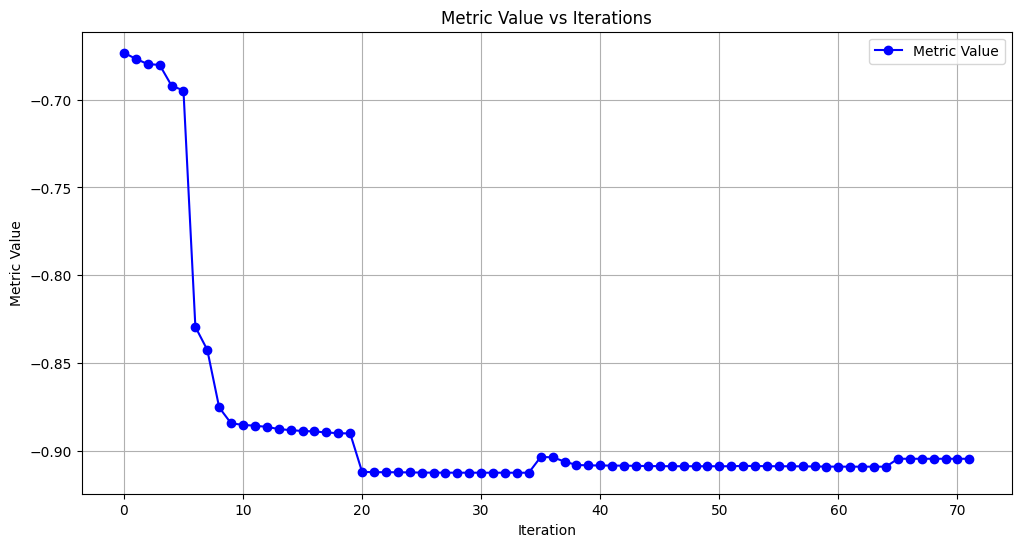

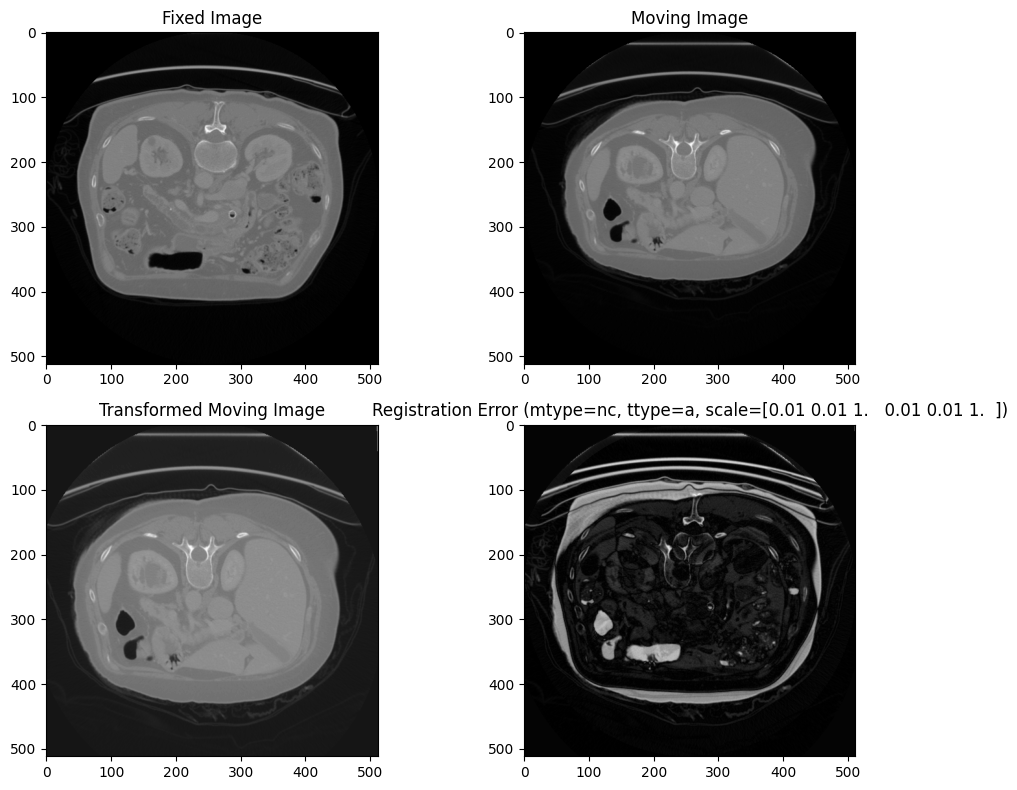

In [22]:
affineReg2D_multi_resolution(Imoving_path, Ifixed_path, levels=5, mtype='nc', ttype='a', epsilon=0.001, tscale= [0.01,0.01,1,0.01,0.01,1], order=3, visualize=True);